In [70]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, HuberRegressor, LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
import catboost as cb
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, probplot, kurtosis
import seaborn as sns
sns.set_style('darkgrid')

In [71]:
pd.set_option('display.max_columns',None)

# ***Initializing Dataset***

In [72]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = df[df.GrLivArea < 4000]

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

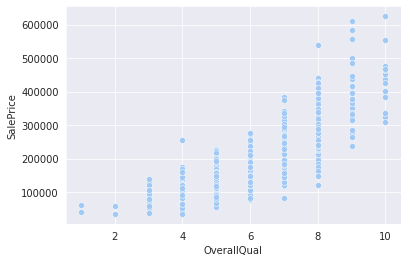

In [73]:
sns.scatterplot(data=df,y="SalePrice",x="OverallQual")

In [74]:
y = df['SalePrice']
df = df.drop(['SalePrice'],axis=1)
df = df.set_index('Id')
test = test.set_index('Id')

# ***Missing Values Imputation***

In [75]:
print("Total null values:")
print(df.isna().sum().sum() + test.isna().sum().sum())
print("\nNull columns and counts in each dataset\n")
for col in df.columns:
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 and test_null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("Missing in test set:" + str(test_null))
        print("\n")
    elif null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("\n")
    elif test_null !=0:
        print(col,test[col].dtypes)
        print("Missing in test set:" +  str(test_null))
        print("\n")
    

Total null values:
13952

Null columns and counts in each dataset

MSZoning object
Missing in test set:4


LotFrontage float64
Missing in train set:259
Missing in test set:227


Alley object
Missing in train set:1365
Missing in test set:1352


Utilities object
Missing in test set:2


Exterior1st object
Missing in test set:1


Exterior2nd object
Missing in test set:1


MasVnrType object
Missing in train set:8
Missing in test set:16


MasVnrArea float64
Missing in train set:8
Missing in test set:15


BsmtQual object
Missing in train set:37
Missing in test set:44


BsmtCond object
Missing in train set:37
Missing in test set:45


BsmtExposure object
Missing in train set:38
Missing in test set:44


BsmtFinType1 object
Missing in train set:37
Missing in test set:42


BsmtFinSF1 float64
Missing in test set:1


BsmtFinType2 object
Missing in train set:38
Missing in test set:42


BsmtFinSF2 float64
Missing in test set:1


BsmtUnfSF float64
Missing in test set:1


TotalBsmtSF float64
Missing in 

We will have to impute those missing values with the most sensable method by looking at them one at a time  

**MSZoning** : Identifies the general zoning classification of the sale.  
       A	Agriculture  
       C	Commercial  
       FV	Floating Village Residential  
       I	Industrial  
       RH	Residential High Density  
       RL	Residential Low Density  
       RP	Residential Low Density Park   
       RM	Residential Medium Density  

In [76]:
full = pd.concat([df,test],axis=0).reset_index(drop=True)

,Neighborhood,MSZoning
Id,,
1916,IDOTRR,NaN
2217,IDOTRR,NaN
2251,IDOTRR,NaN
2905,Mitchel,NaN


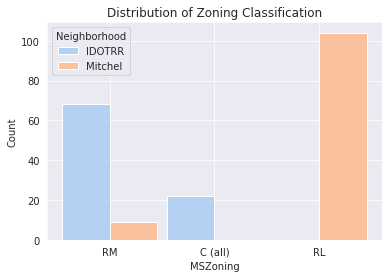

In [77]:
sns.set_palette(sns.color_palette("pastel"))
null = test[test['MSZoning'].isnull()][["Neighborhood","MSZoning"]]
display(null)
plot_data = pd.concat([full[full['Neighborhood'] == 'IDOTRR'],full[full['Neighborhood'] == 'Mitchel']],axis = 0)
fig, ax = plt.subplots()
sns.histplot(data = plot_data, x ='MSZoning', hue ='Neighborhood',multiple="dodge", shrink=.9)
plt.title("Distribution of Zoning Classification")
plt.show()

Since the general zoning classification usually depends on the neighborhood, we will impute the missing value by the mode in the area.

In [78]:
test.loc[(test['Neighborhood'] == 'IDOTRR') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RM'
test.loc[(test['Neighborhood'] == 'Mitchel') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RL'

**LotFrontage** : Linear feet of street connected to property  
We expect LotFrontage to be somewhat correlated with LotArea. Hence we will use LinearRegression to impute the missing values.

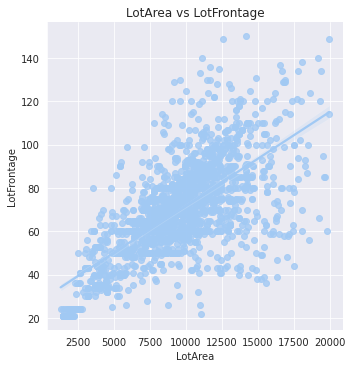

In [79]:
sns.set_palette(sns.color_palette("pastel"))
data = full[(~full['LotFrontage'].isnull()) & (full['LotFrontage'] <= 150) & (full['LotArea'] <= 20000)]
sns.lmplot(data=data,x="LotArea",y="LotFrontage")
plt.ylabel("LotFrontage")
plt.xlabel("LotArea")
plt.title("LotArea vs LotFrontage")
plt.show()

In [80]:
area_vs_frontage = LinearRegression()
area_vs_frontage_X = data['LotArea'].values.reshape(-1, 1)
area_vs_frontage_y = data['LotFrontage'].values
area_vs_frontage.fit(area_vs_frontage_X,area_vs_frontage_y)
for table in [df,test]:
    table['LotFrontage'].fillna(area_vs_frontage.intercept_ + table['LotArea'] * area_vs_frontage.coef_[0] , inplace=True)

**Alley** : data description says NA means no alley access

In [81]:
for table in [df,test]:
    table['Alley'].fillna("None",inplace=True)

**Utilities** : Type of utilities available

In [82]:
full['Utilities'].value_counts()

AllPub    2912
NoSeWa       1
Name: Utilities, dtype: int64

In [83]:
test['Utilities'].fillna("AllPub",inplace=True)

In [84]:
df[df['Utilities'] == 'NoSeWa'].index

Int64Index([945], dtype='int64', name='Id')

In [85]:
df.drop(945, inplace = True)

In [86]:
test['Exterior1st'] = test['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])

**MasVnrType** : data description says NA means no Masonry veneer. However wo notice one data in test set with area but missing type.

In [87]:
test[(test['MasVnrType'].isnull()) & (test['MasVnrArea'].notnull())][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
2611,NaN,198.0


In [88]:
test['MasVnrType'][2611] = full['MasVnrType'].mode()[0]
test['MasVnrType'] = test['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

**BsmtFinType1** : data description says this metric measures the Type 1 finished square feet of basement.  
However, we can see a few data in test data set having basement metrics but "0" squarefeets

In [89]:
for basement_metrics_cols in ['BsmtExposure','BsmtCond','BsmtQual']:
    if len(full[(full[basement_metrics_cols].notnull()) & (full['BsmtFinType1'].isnull())]) > 0 :
        print("Present with BsmtFinType1 but undetected" + basement_metrics_cols)
        display(full[(full[basement_metrics_cols].notnull()) & (full['BsmtFinType1'].isnull())])

In [90]:
for basement_metrics_cols in ['BsmtExposure','BsmtCond','BsmtQual']:
    if len(full[(full[basement_metrics_cols].isnull()) & (full['BsmtFinType1'].notnull())]) > 0 :
        print("\nPresent with "+ basement_metrics_cols+" but BsmtFinType1 undetected" )
        display(full[(full[basement_metrics_cols].isnull()) & (full['BsmtFinType1'].notnull())])


Present with BsmtExposure but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
946,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,144.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936,840,0,1776,0.0,0.0,2,1,3,1,Gd,7,Typ,1,TA,Attchd,2002.0,RFn,2.0,474.0,TA,TA,Y,144,96,0,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal
1483,20,RL,73.0,8987,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,BrkFace,226.0,Gd,TA,PConc,Gd,TA,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595,0,0,1595,0.0,0.0,2,0,2,1,Gd,6,Typ,1,Gd,Attchd,2005.0,RFn,3.0,880.0,TA,TA,Y,144,0,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
2344,60,FV,81.0,10411,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,2Story,5,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,CBlock,Gd,TA,NaN,Unf,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725,863,0,1588,0.0,0.0,3,0,3,1,Gd,8,Typ,0,NaN,Attchd,2007.0,Unf,2.0,561.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,7,2007,New,Partial



Present with BsmtCond but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2036,20,RL,103.0,16280,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,9,1976,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Ex,Ex,CBlock,Gd,NaN,Mn,GLQ,1044.0,Rec,382.0,0.0,1426.0,GasA,Ex,Y,SBrkr,1671,0,0,1671,1.0,0.0,3,0,3,1,Ex,6,Typ,1,Gd,Attchd,1976.0,RFn,2.0,550.0,TA,TA,Y,280,90,0,0,0,0,NaN,GdWo,NaN,0,5,2008,WD,Normal
2181,20,RL,65.0,6500,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,6,6,1976,1976,Hip,CompShg,HdBoard,Plywood,BrkFace,84.0,TA,TA,CBlock,TA,NaN,No,BLQ,1033.0,Unf,0.0,94.0,1127.0,GasA,TA,Y,SBrkr,1127,0,0,1127,0.0,1.0,1,1,3,1,TA,6,Typ,1,Po,Detchd,1991.0,Unf,2.0,480.0,TA,TA,Y,0,0,138,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
2520,80,RL,72.0,9720,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SLvl,5,7,1977,1977,Gable,CompShg,Plywood,VinylSd,BrkFace,51.0,TA,TA,CBlock,TA,NaN,Av,ALQ,755.0,Unf,0.0,240.0,995.0,GasA,TA,Y,SBrkr,1009,0,0,1009,0.0,0.0,2,0,3,1,TA,6,Typ,1,Fa,Detchd,1977.0,Unf,2.0,576.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal



Present with BsmtQual but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2213,70,C (all),60.0,5280,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,7,1895,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,Stone,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA,Ex,N,SBrkr,825,536,0,1361,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1895.0,Unf,1.0,185.0,Fa,TA,Y,0,123,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
2214,50,C (all),52.0,5150,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Feedr,Norm,1Fam,1.5Fin,4,7,1910,2000,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,PConc,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA,TA,N,FuseA,671,378,0,1049,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Detchd,1910.0,Unf,1.0,195.0,Po,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


In [91]:
# We assume missing basement exposure of unfinished basement is "No".
df.loc[((df['BsmtExposure'].isnull()) & (df['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
test.loc[((test['BsmtExposure'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
# We impute missing basement condition with "mean" value of Typical.
test.loc[((test['BsmtCond'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtCond'] = 'TA'
# We impute unfinished basement quality with "mean" value of Typical.
test.loc[((test['BsmtQual'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtQual'] = 'TA'

There is one test data with missing square feet values. Let's check it out

In [92]:
test[test['BsmtFinSF1'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


This test data do not have basement. Hence, those squarefeets metrics should be filled in with 0.

In [93]:
for square_feet_metrics in ['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']:
    test[square_feet_metrics][2121] = 0

There is two test data with missing basement bathroom values. Let's check them out first too.

In [94]:
test[test['BsmtFullBath'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,Gtl,BrkSide,Feedr,Norm,1Fam,1Story,4,7,1946,1950,Gable,CompShg,MetalSd,CBlock,None,0.0,TA,TA,PConc,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,FuseA,896,0,0,896,NaN,NaN,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1946.0,Unf,1.0,280.0,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml
2189,20,RL,123.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1959,1996,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,TA,Y,SBrkr,3820,0,0,3820,NaN,NaN,3,1,5,1,Ex,11,Typ,2,Gd,Attchd,1959.0,Unf,2.0,624.0,TA,TA,Y,0,372,0,0,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


The two test data do not have basement. Hence, those bathroom amount in basement should also be filled in with 0.

In [95]:
for bathroom_metrics in ['BsmtFullBath','BsmtHalfBath']:
    test[bathroom_metrics][2121] = 0
    test[bathroom_metrics][2189] = 0

The other data are assumed to not have basements hence filling in None.

In [96]:
for table in [df,test]:
    table[table.columns[table.columns.str.contains('Bsmt')]] = table[table.columns[table.columns.str.contains('Bsmt')]].fillna("None")

In [97]:
for metrics in ['Electrical','Functional','KitchenQual']:
    print(full[metrics].value_counts(normalize=True))
    print("\n")

SBrkr    0.915237
FuseA    0.064516
FuseF    0.017159
FuseP    0.002745
Mix      0.000343
Name: Electrical, dtype: float64


Typ     0.931342
Min2    0.024030
Min1    0.022314
Mod     0.012015
Maj1    0.006522
Maj2    0.003090
Sev     0.000687
Name: Functional, dtype: float64


TA    0.512011
Gd    0.394990
Ex    0.068977
Fa    0.024022
Name: KitchenQual, dtype: float64




These three metrics are safe to be filled with the mode values.

In [98]:
df['Electrical'].fillna('SBrkr',inplace=True)
test['Functional'].fillna('Typ',inplace=True)
test['KitchenQual'].fillna('TA',inplace=True)

In [99]:
full[full['GarageCars'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2572,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


Simililarly, this test data do not have a garage, filling GarageArea and GarageCars with 0.

In [100]:
test['GarageCars'].fillna(0,inplace=True)
test['GarageArea'].fillna(0,inplace=True)

In [101]:
display(full[full['SaleType'].isnull()])
print(full['SaleType'].value_counts(normalize=True))

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2485,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2007,NaN,Normal


WD       0.865820
New      0.081332
COD      0.029856
ConLD    0.008922
CWD      0.004118
ConLI    0.003089
ConLw    0.002745
Oth      0.002402
Con      0.001716
Name: SaleType, dtype: float64


For the SaleType column, we will impute the missing data with the mode since the mode value is kinda high too.

In [102]:
test['SaleType'].fillna('WD',inplace=True)

It's now a good time to recheck all other remaining missing values.

In [103]:
print("Total null values:")
print(df.isna().sum().sum() + test.isna().sum().sum())
print("\nNull columns and counts in each dataset\n")
for col in df.columns:
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 and test_null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("Missing in test set:" + str(test_null))
        print("\n")
    elif null != 0:
        print(col,df[col].dtypes)
        print("Missing in train set:" +  str(null))
        print("\n")
    elif test_null !=0:
        print(col,test[col].dtypes)
        print("Missing in test set:" +  str(test_null))
        print("\n")
    

Total null values:
10272

Null columns and counts in each dataset

FireplaceQu object
Missing in train set:690
Missing in test set:730


GarageType object
Missing in train set:81
Missing in test set:76


GarageYrBlt float64
Missing in train set:81
Missing in test set:78


GarageFinish object
Missing in train set:81
Missing in test set:78


GarageQual object
Missing in train set:81
Missing in test set:78


GarageCond object
Missing in train set:81
Missing in test set:78


PoolQC object
Missing in train set:1450
Missing in test set:1456


Fence object
Missing in train set:1175
Missing in test set:1169


MiscFeature object
Missing in train set:1401
Missing in test set:1408




We do not have anything extra to infer these missing columns. Hence, we will treat them as "None" which is not having those items.

In [104]:
df['GarageYrBlt'].fillna(0,inplace=True)
test['GarageYrBlt'].fillna(0,inplace=True)
df.fillna("None", inplace=True)
test.fillna("None", inplace=True)

In [105]:
df.isnull().sum().sum() + test.isnull().sum().sum()

0

In [106]:
df.index = df.index - 1

# ***Feature Engineering***


 mu = 180151.23 and sigma = 76670.25



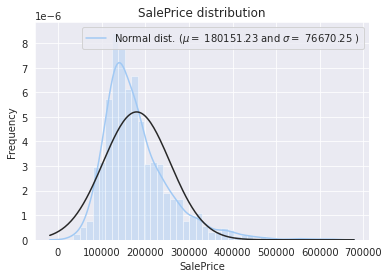

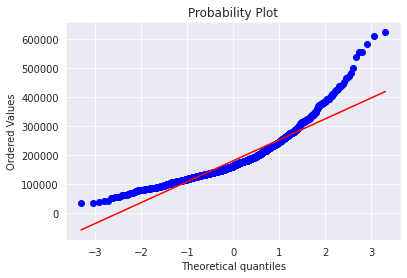

In [107]:
sns.distplot(y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

The target variable seems to be right skewed. We will have to transform it to be more normally distributed.

In [108]:
y = np.log(y)


 mu = 12.02 and sigma = 0.40



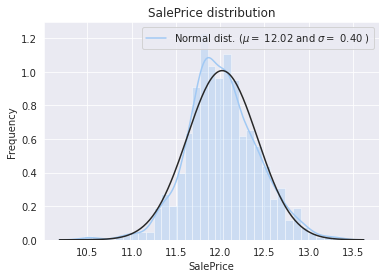

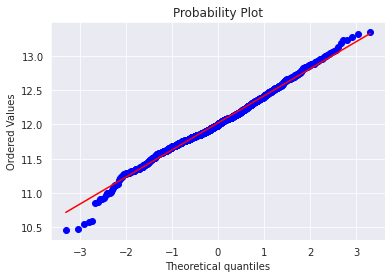

In [109]:
sns.distplot(y , fit=norm);
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

In [110]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [111]:
for table in [df,test]:
    table['MSSubClass'] = table['MSSubClass'].apply(str)
    table['YrSold'] = table['YrSold'].astype(str)
    table['MoSold'] = table['MoSold'].astype(str)

In [112]:
qual_dict = {'None': 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_fin_dict = {'None': 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}

for table in [df,test]:
    table["ExterQual"] = table["ExterQual"].map(qual_dict)
    table["ExterCond"] = table["ExterCond"].map(qual_dict)
    table["BsmtQual"] = table["BsmtQual"].map(qual_dict)
    table["BsmtCond"] = table["BsmtCond"].map(qual_dict)
    table["PoolQC"] = table["PoolQC"].map(qual_dict)
    table["HeatingQC"] = table["HeatingQC"].map(qual_dict)
    table["KitchenQual"] = table["KitchenQual"].map(qual_dict)
    table["FireplaceQu"] = table["FireplaceQu"].map(qual_dict)
    table["GarageQual"] = table["GarageQual"].map(qual_dict)
    table["GarageCond"] = table["GarageCond"].map(qual_dict)

    table["BsmtExposure"] = table["BsmtExposure"].map(
        {'None': 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}) 
    table["BsmtFinType1"] = table["BsmtFinType1"].map(bsmt_fin_dict)
    table["BsmtFinType2"] = table["BsmtFinType2"].map(bsmt_fin_dict)

    table["Functional"] = table["Functional"].map(
        {'None': 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8})

    table["GarageFinish"] = table["GarageFinish"].map(
        {'None': 0, "Unf": 1, "RFn": 2, "Fin": 3})

    table["Fence"] = table["Fence"].map(
        {'None': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4})
    
    table["CentralAir"] = table["CentralAir"].map(
        {'N': 0, "Y": 1})
    
    table["PavedDrive"] = table["PavedDrive"].map(
        {'N': 0, "P": 1, "Y": 2})

    
    table["Street"] = table["Street"].map(
        {'Grvl': 0, "Pave": 1})
    
    table["Alley"] = table["Alley"].map(
        {'None': 0, "Grvl": 1, "Pave": 2})
    
    table["LandSlope"] = table["LandSlope"].map(
        {'Gtl': 0, "Mod": 1, "Sev": 2})
    
    
modified_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual' \
                    ,'FireplaceQu','GarageQual','GarageCond','BsmtExposure','BsmtFinType1' \
                   ,'BsmtFinType2', 'Functional','GarageFinish','Fence','Street','Alley','LandSlope'\
                    ,'PavedDrive' ,'CentralAir','PoolQC','OverallQual','OverallCond']

# Get list of categorical variables in holiday dataset
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
object_cols = [x for x in object_cols if x not in modified_cols]

MSZoning 5
['RL' 'RM' 'C (all)' 'FV' 'RH' nan]


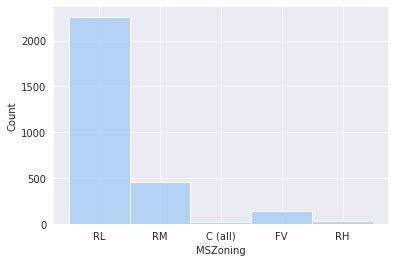

LotShape 4
['Reg' 'IR1' 'IR2' 'IR3']


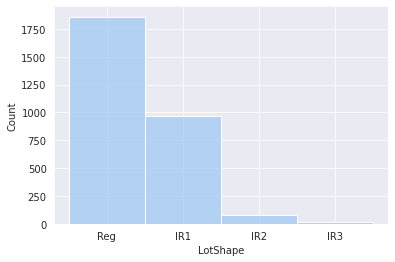

LandContour 4
['Lvl' 'Bnk' 'Low' 'HLS']


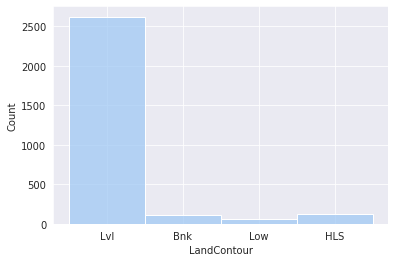

Utilities 2
['AllPub' 'NoSeWa' nan]


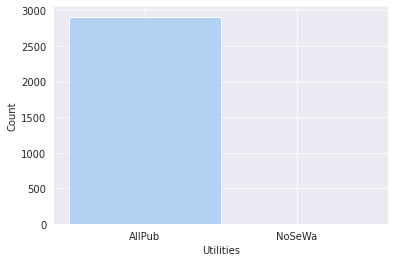

LotConfig 5
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']


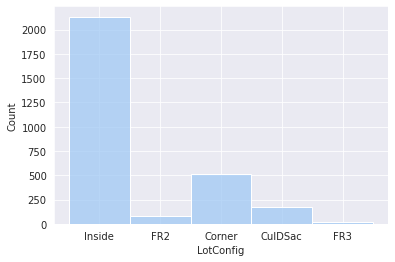

Condition1 9
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']


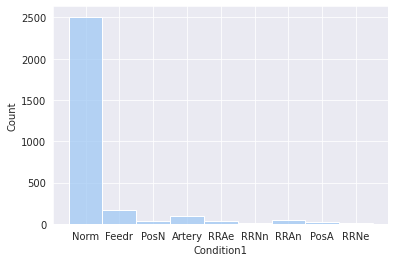

Condition2 8
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosA' 'PosN' 'RRAn' 'RRAe']


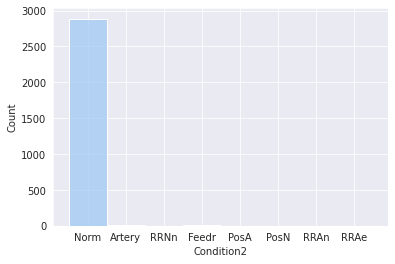

BldgType 5
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']


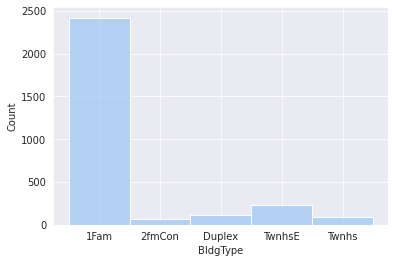

HouseStyle 8
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']


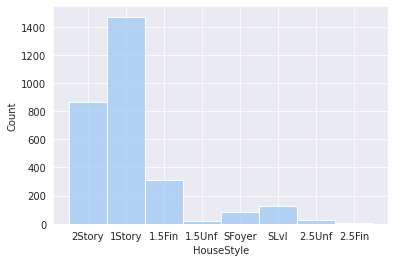

RoofStyle 6
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']


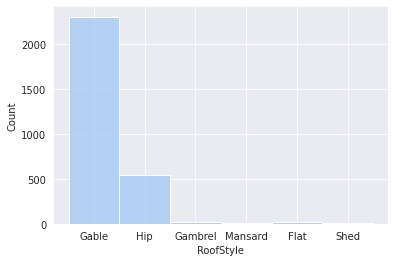

RoofMatl 7
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll']


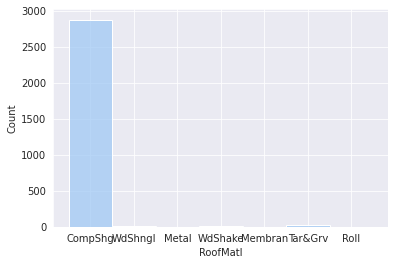

MasVnrType 4
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


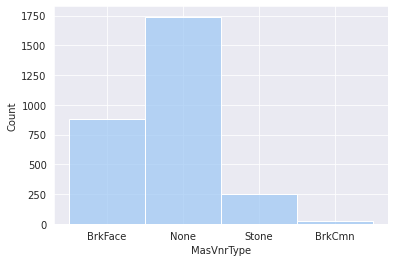

Foundation 6
['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']


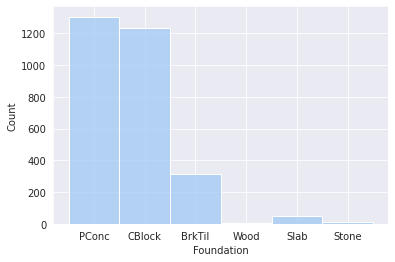

Heating 6
['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']


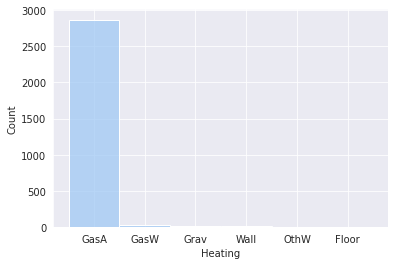

Electrical 5
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


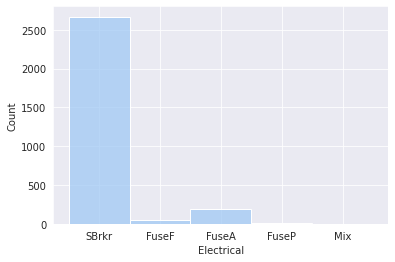

GarageType 6
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


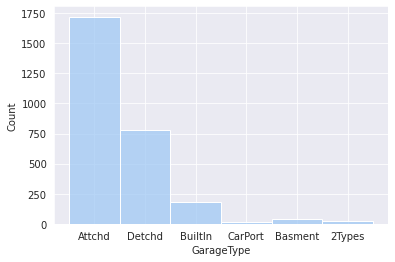

MiscFeature 4
[nan 'Shed' 'Gar2' 'Othr' 'TenC']


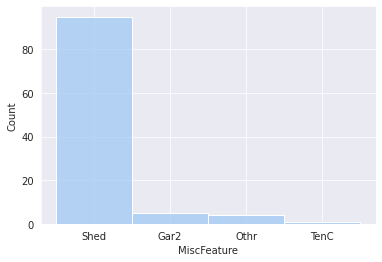

MoSold 12
[ 2  5  9 12 10  8 11  4  1  7  3  6]


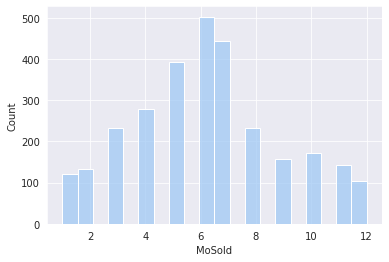

YrSold 5
[2008 2007 2006 2009 2010]


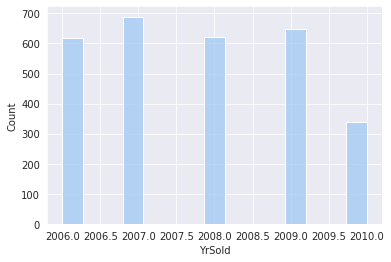

SaleType 9
['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth' nan]


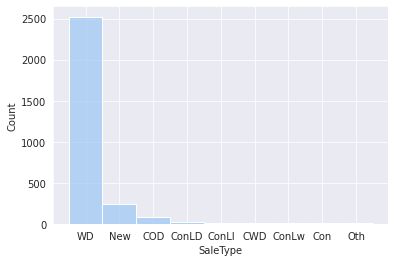

SaleCondition 6
['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family']


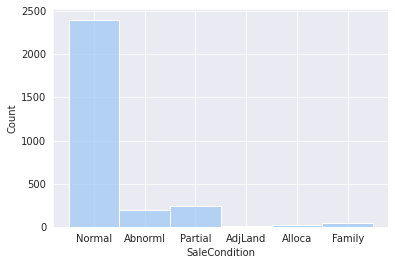

In [113]:
for col in object_cols:
    if len(full[col].unique())<=12:
        print(col,full[col].nunique())
        print(full[col].unique())
        sns.histplot(data = full, x=col)
        plt.show()

In [114]:
cond_1_keep = ['Norm','Feedr','Artery']
roof_style_keep = ['Gable','Hip']
foundation_keep = ['PConc','CBlock','BrkTil']
garage_keep = ['Attchd','Detchd','BuiltIn']
sale_keep = ['WD','New','COD']
sale_cond_keep = ['Normal','Abnorml','Partial']
peak_months = ['5','6','7']

for table in [df,test]:
    table.loc[table['LandContour']!='Lvl','LandContour'] = "Others"
    
    table.loc[~table['Condition1'].isin(cond_1_keep),'Condition1'] = "Others"
    table.loc[table['Condition2']!="Norm",'Condition2'] = "Others"
    
    table.loc[~table['RoofStyle'].isin(roof_style_keep),'RoofStyle'] = "Others"
    table.loc[table['RoofMatl']!='CompShg','RoofMatl'] = "Others"
    
    table.loc[~table['Foundation'].isin(foundation_keep),'Foundation'] = "Others"
    table.loc[table['Heating']!='GasA','Heating'] = "Others"
    table.loc[table['Electrical']!='SBrkr','Electrical'] = "Others"
    
    table.loc[~table['GarageType'].isin(garage_keep),'GarageType'] = "Others"
    
    table.loc[~table['SaleType'].isin(sale_keep),'SaleType'] = "Others"
    table.loc[~table['SaleCondition'].isin(sale_cond_keep),'SaleCondition'] = "Others"
    table.loc[~table['SaleCondition'].isin(sale_cond_keep),'SaleCondition'] = "Others"
    
    table.loc[table['MoSold'].isin(peak_months),'PeakMonths'] = 1
    table.loc[table['PeakMonths']!=1,'PeakMonths'] = 0

In [115]:
low_cardinality_cols=[]
med_cardinality_cols=[]

for col in df[object_cols]:
    if len(df[col].unique())<=10:
        low_cardinality_cols.append(col)
    elif len(df[col].unique())>10:
        med_cardinality_cols.append(col)

med_cardinality_cols.remove('MSSubClass')
low_cardinality_cols.append('MSSubClass')
# One Hot Encoding for Low Cardinality Columns
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(df[low_cardinality_cols]))
OH_cols.index = df.index
OH_cols.columns = OH_encoder.get_feature_names(low_cardinality_cols)
df = df.drop(low_cardinality_cols, axis=1)
df = pd.concat([df, OH_cols], axis=1)

OH_cols = pd.DataFrame(OH_encoder.transform(test[low_cardinality_cols]))
OH_cols.index = test.index
OH_cols.columns = OH_encoder.get_feature_names(low_cardinality_cols)
test = test.drop(low_cardinality_cols, axis=1)
test = pd.concat([test, OH_cols], axis=1)

# Ordinal Encoding for Medium Cardinality Columns
label_encoder = OrdinalEncoder()
df[med_cardinality_cols] = label_encoder.fit_transform(df[med_cardinality_cols])
test[med_cardinality_cols] = label_encoder.transform(test[med_cardinality_cols])

In [116]:
skewed = df[df.columns[~df.columns.isin(list(OH_cols.columns) + modified_cols + med_cardinality_cols)]].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.5]
skewed = skewed.index

df[skewed] = np.log1p(df[skewed])
test[skewed] = np.log1p(test[skewed])

In [117]:
for col in df[df.columns]:
    if col not in (list(OH_cols.columns) + modified_cols + med_cardinality_cols):
        scaler = RobustScaler()
        df[col] = scaler.fit_transform(df[[col]])
        test[col] = scaler.transform(test[[col]])

In [118]:
full = pd.merge(left = df, right = y , left_index= True, right_index = True)
train, dev = train_test_split(full, test_size=0.2 ,shuffle=True)

train_y = train['SalePrice']
train_X = train.drop(['SalePrice'],axis=1)

dev_y = dev['SalePrice']
dev_X = dev.drop(['SalePrice'],axis=1)

In [119]:
# rfmodel = RandomForestRegressor(n_jobs=-1)
# rfparams = {
#     'max_depth' : [26],
#     'n_estimators' : [1000],
#     'min_samples_leaf':[4],
#     'max_features': ['auto'],
#     'oob_score' : [True],
#     'min_samples_split' : [4],
#     'ccp_alpha' : [0.00005],
#     'max_samples' : [0.65]
# }
# rfgrid = GridSearchCV(estimator = rfmodel,verbose=4, param_grid = rfparams, cv = 10, scoring = 'neg_root_mean_squared_error')
# rfgrid.fit(train_X,train_y)
# print(rfgrid.best_params_)
# print(rfgrid.best_score_)
# print(rfgrid.score(dev_X,dev_y))
# print(rfgrid.score(train_X,train_y))

In [120]:
rfmodel = RandomForestRegressor(ccp_alpha= 0.00005, max_depth=26, max_features= 'auto', max_samples=0.6, min_samples_leaf= 4, min_samples_split= 4, n_estimators= 5000, oob_score= True)
rfmodel.fit(train_X,train_y)
print(mean_squared_error(dev_y,rfmodel.predict(dev_X),squared=False))
print(mean_squared_error(train_y,rfmodel.predict(train_X),squared=False))

0.13252514846255767
0.0990355752743746


In [121]:
# xgbmodel = XGBRegressor(n_jobs=-1)
# xgbparams = {
#     'max_depth' : [3],
#     'n_estimators' : [10000],
#     'learning_rate' : [0.01],
#     'colsample_bytree' : [0.6],
#     'subsample':[0.65],
#     'alpha' : [3],
#     'lambda' : [3],
# }
# xgbgrid = GridSearchCV(estimator = xgbmodel,verbose=3, param_grid = xgbparams, cv = 5, scoring = 'neg_root_mean_squared_error')
# xgbgrid.fit(train_X,train_y)
# print(xgbgrid.best_params_)
# print(xgbgrid.best_score_)
# print(xgbgrid.score(dev_X,dev_y))
# print(xgbgrid.score(train_X,train_y))

In [122]:
xgbmodel = XGBRegressor(alpha= 3, colsample_bytree=0.6, reg_lambda=3, learning_rate= 0.01, max_depth=3, n_estimators=10000, subsample=0.65)
xgbmodel.fit(train_X,train_y)

XGBRegressor(alpha=3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=3, scale_pos_weight=1, subsample=0.65,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [123]:
# ridgemodel = Ridge()
# ridgeparams = {
#     'alpha' : [3]
# }
# ridgegrid = GridSearchCV(estimator = ridgemodel,verbose=3, param_grid = ridgeparams, cv = 10, scoring = 'neg_root_mean_squared_error')
# ridgegrid.fit(train_X,train_y)
# print(ridgegrid.best_params_)
# print(ridgegrid.best_score_)
# print(ridgegrid.score(dev_X,dev_y))
# print(ridgegrid.score(train_X,train_y))

In [124]:
ridgemodel = Ridge(alpha=3)
ridgemodel.fit(train_X,train_y)
print(mean_squared_error(dev_y,ridgemodel.predict(dev_X),squared=False))
print(mean_squared_error(train_y,ridgemodel.predict(train_X),squared=False))

0.1080108940167005
0.10341885863956712


In [125]:
# svrmodel = SVR()
# svrparams = {
#     'C' : [35],
#     'epsilon' : [0.008],
#     'gamma' : [0.0008]
# }
# svrgrid = GridSearchCV(estimator = svrmodel,verbose=3, param_grid = svrparams, cv = 10, scoring = 'neg_root_mean_squared_error')
# svrgrid.fit(train_X,train_y)
# print(svrgrid.best_params_)
# print(svrgrid.best_score_)
# print(svrgrid.score(dev_X,dev_y))
# print(svrgrid.score(train_X,train_y))

In [126]:
svrmodel = SVR(C=35,epsilon=0.008,gamma=0.0008)
svrmodel.fit(train_X,train_y)

SVR(C=35, epsilon=0.008, gamma=0.0008)

In [127]:
# hubermodel = HuberRegressor()
# huberparams = {
#     'epsilon' : [5],
#     'alpha' : [20],
#     'max_iter' : [600],
#     'fit_intercept' : [True]
# }
# hubergrid = GridSearchCV(estimator = hubermodel,verbose=3, param_grid = huberparams, cv = 10, scoring = 'neg_root_mean_squared_error')
# hubergrid.fit(train_X,train_y)
# print(hubergrid.best_params_)
# print(hubergrid.best_score_)
# print(hubergrid.score(dev_X,dev_y))
# print(hubergrid.score(train_X,train_y))

In [128]:
hubermodel = HuberRegressor(alpha=20,epsilon=5,fit_intercept=True,max_iter=600)
hubermodel.fit(train_X,train_y)

HuberRegressor(alpha=20, epsilon=5, max_iter=600)

In [129]:
# lightgbm = LGBMRegressor(objective='regression')
# lightgbmparams = {
#     'learning_rate' :[0.0005], 
#     'n_estimators' : [50000],
#     'reg_alpha' : [2],
#     'reg_lambda' : [2],
#     'max_depth' : [3],
#     'min_split_gain' : [0.005],
#     'subsample' : [0.7],
#     'colsample_bytree' : [0.7],
#     'extra_trees' : [True]
# }
# lightgbmgrid = GridSearchCV(estimator = lightgbm,verbose=3, param_grid = lightgbmparams, cv = 10, scoring = 'neg_root_mean_squared_error')
# lightgbmgrid.fit(train_X,train_y)
# print(lightgbmgrid.best_params_)
# print(lightgbmgrid.best_score_)
# print(lightgbmgrid.score(dev_X,dev_y))
# print(lightgbmgrid.score(train_X,train_y))

In [130]:
lightgbm = LGBMRegressor(objective='regression',learning_rate=0.0005, 
    n_estimators=50000,
    reg_alpha=2,
    reg_lambda=2,
    max_depth=3,
    min_split_gain=0.005,
    subsample=0.7,
    colsample_bytree=0.7,
    extra_trees=True)
lightgbm.fit(train_X, train_y)

LGBMRegressor(colsample_bytree=0.7, extra_trees=True, learning_rate=0.0005,
              max_depth=3, min_split_gain=0.005, n_estimators=50000,
              objective='regression', reg_alpha=2, reg_lambda=2, subsample=0.7)

In [131]:
# cbmodel = cb.CatBoostRegressor(objective='regression',
#                                loss_function='RMSE')
# cbparams = {
# 'colsample_bylevel':[0.5], 
# 'depth':[2], 
# 'l2_leaf_reg':[50], 
# 'learning_rate':[0.005], 
# 'n_estimators':[15000], 
# 'subsample':[0.5]
# }

# cbgrid = GridSearchCV(estimator = cbmodel,verbose=3, param_grid = cbparams, cv = 10, scoring = 'neg_root_mean_squared_error')
# cbgrid.fit(train_X,train_y)
# print(cbgrid.best_params_)
# print(cbgrid.best_score_)
# print(cbgrid.score(dev_X,dev_y))
# print(cbgrid.score(train_X,train_y))

In [132]:
cbmodel = cb.CatBoostRegressor(loss_function='RMSE',colsample_bylevel=0.5, depth=2, l2_leaf_reg=50, learning_rate=0.005, n_estimators=15000, subsample=0.5,verbose=False)
cbmodel.fit(train_X, train_y)

In [133]:
stackmodel = StackingCVRegressor(regressors=(ridgemodel, xgbmodel, rfmodel, hubermodel, cbmodel),
                                meta_regressor=cbmodel,
                                use_features_in_secondary=True)
stackmodel.fit(np.array(train_X), np.array(train_y))
stackpred = stackmodel.predict(np.array(dev_X))
stackfit = stackmodel.predict(np.array(train_X))

In [134]:
for i in [rfmodel,xgbmodel,stackmodel,ridgemodel,lightgbm,hubermodel,cbmodel]:
    print(i)
    print(mean_squared_error(dev_y,i.predict(dev_X), squared=False))
    print(mean_squared_error(train_y,i.predict(train_X), squared=False))
    print("\n")

RandomForestRegressor(ccp_alpha=5e-05, max_depth=26, max_samples=0.6,
                      min_samples_leaf=4, min_samples_split=4,
                      n_estimators=5000, oob_score=True)
0.13252514846255767
0.0990355752743746


XGBRegressor(alpha=3, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=3,
             reg_lambda=3, scale_pos_weight=1, subsample=0.65,
             tree_method='exact', validate_parameters=1, verbosity=None)
0.1144299877811245
0.08663507659689314


StackingCVRegressor(meta_regressor=<catboost.core.CatBoostRegressor object at 0x7f82d762bc

In [135]:
pred = (rfmodel.predict(dev_X) + xgbmodel.predict(dev_X) +  stackmodel.predict(dev_X) + ridgemodel.predict(dev_X) + lightgbm.predict(dev_X) + hubermodel.predict(dev_X) + cbmodel.predict(dev_X)) / 7
print(mean_squared_error(dev_y,pred, squared=False))

0.10793072851237584


In [136]:
fit = (rfmodel.predict(train_X) + xgbmodel.predict(train_X) + lightgbm.predict(train_X) +   stackmodel.predict(train_X) + ridgemodel.predict(train_X) + hubermodel.predict(train_X) + cbmodel.predict(train_X)) / 7
print(mean_squared_error(train_y,fit, squared=False))

0.08913168362807375


In [140]:
final_prediction = (np.exp(ridgemodel.predict(test))+ 2 * np.exp(xgbmodel.predict(test)) \
 + np.exp(rfmodel.predict(test)) + 2 * np.exp(stackmodel.predict(test)) \
 + np.exp(hubermodel.predict(test)) + 2 * np.exp(lightgbm.predict(test)) + 2 * np.exp(cbmodel.predict(test))) / 11 

In [141]:
submission = pd.DataFrame(final_prediction, index = test.index)

In [142]:
submission.reset_index(drop=False, inplace = True)
submission = submission.rename(columns={0 : 'SalePrice', 'index' : 'Id'})
submission.to_csv('submission_v11.csv', index=False)